In [62]:
import sys; sys.path.append('..') # add project root to the python path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from src.part2.tensorized_dp import TensorDP
from src.common.gridworld import GridworldEnv
from src.common.grid_visualization import visualize_value_function, visualize_policy

np.random.seed(0)

In [74]:
nx=3
ny=3
env=GridworldEnv([ny,nx])
#3X3 격자 구조 세계 구축

## 동적계획법 '에이전트' 초기화하기

동적 게획법은 원래 `에이전트`라는 개념을 사용하지 않지만, 일반적으로 사용되는 강화학습의 구현 템플릿에 대한 이해를 돕기 위해 `에이전트`라는 개념을 적용하였습니다.

```python
class TensorDP:
    
    def __init__(self,
                 gamma=1.0,
                 error_tol=1e-5):
        ...
        
```

`TensorDP` 클래스는 2개의 파라미터를 받습니다. 
감소율 `gamma` 와 가치평가/반복 알고리즘에서 수렴조건을 확인할 때 사용하는 수치적 에러의 허용치인 `error_tol` 입니다. 이 예제에서는 각각 `1.0` 과 `1e-5`로 설정하겠습니다.

In [76]:
dp_agent=TensorDP()
#agent 정의

### DP agent에게 환경을 설정봅시다!

```python
def set_env(self, env, policy=None):
        self.env = env
        if policy is None:
            self.policy = np.ones([env.nS, env.nA]) / env.nA

        self.ns = env.nS
        self.na = env.nA
        self.P = env.P_tensor  # Rank 3 tensor [num. actions x num. states x num. states]
        self.R = env.R_tensor  # Rank 2 tensor [num. actions x num. states]

        print("Tensor DP agent initialized")
        print("Environment spec:  Num. state = {} | Num. actions = {} ".format(env.nS, env.nA))
```

In [77]:
dp_agent.set_env(env)

Tensor DP agent initialized
Environment spec:  Num. state = 9 | Num. actions = 4 


### $R^{\pi}$ 효율적으로 계산하기

MDP 강의에서 이야기했던대로, $R^{\pi}$ 는 다음과 같이 정의 됩니다.

$$R^{\pi}_s = \sum_{a \in \cal{A}} \pi(a|s) R_s^a $$

각 $R^{\pi}$의 각 원소 $R^{\pi}_s$ 위의 수식으로 정의되고 $R^{\pi}$ 은 모든 상태 $s$ 의 $R^{\pi}_s$를 열 벡터로 표현한 형태가 됩니다. $R^{\pi} \in \mathbb{R}^{|\cal{S}|}$. 

> 예제에서는 구현의 편의를 위해 열 벡터 (Rank1 텐서)에 하나의 축을 더하여 $R^{\pi} \in \mathbb{R}^{|\cal{S}|\times 1}$ 으로 표현하였습니다.

#### Numpy 를 활용해 위의 수식을 구현

```python
def get_r_pi(self, policy):
    r_pi = (policy * self.R).sum(axis=-1)  # [num. states x 1]
    return r_pi
```

In [78]:
df = pd.DataFrame(dp_agent.get_p_pi(dp_agent.policy))
df

,0,1,2,3,4,5,6,7,8
0,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.25,0.25,0.25,0.00,0.25,0.00,0.00,0.00,0.00
2,0.00,0.25,0.50,0.00,0.00,0.25,0.00,0.00,0.00
3,0.25,0.00,0.00,0.25,0.25,0.00,0.25,0.00,0.00
4,0.00,0.25,0.00,0.25,0.00,0.25,0.00,0.25,0.00
5,0.00,0.00,0.25,0.00,0.25,0.25,0.00,0.00,0.25
6,0.00,0.00,0.00,0.25,0.00,0.00,0.50,0.25,0.00
7,0.00,0.00,0.00,0.00,0.25,0.00,0.25,0.25,0.25
8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00


### $P^{\pi}$ 효율적으로 계산하기

$P^{\pi}$ 는 다음과 같이 정의 됩니다.

$$P^{\pi}_{ss'} = \sum_{a \in \cal{A}} \pi(a|s) P_{ss'}^a $$

각 $P^{\pi}_{ss'}$는 상태천이 행렬 (이번에는 정말 행렬입니다!) 의 $s$번째 열(row) $s'$번째 행(column)의 원소입니다. 따라서 $P^{\pi} \in \mathbb{R}^{|\cal{S}|\times|\cal{S}|}$는 행렬입니다.
위의 수식을 도식화해서 표현하면 다음과 같은 그림이 됩니다.

<img src="./images/tensorized_p_computation.png" width="80%" height="50%" title="px(픽셀) 크기 설정" alt="Tensor"></img>

눈치가 좋으신분들은 (그래서 여러분들은) 아마도 이 연산이 기존의 매트릭스 곱하기 및 원소별 곱하기 (element-wise product, aka, Hadamard product) 등으로는 표현하기에 까다롭다는것을 알아채셨으리라 생각합니다. 이런 경우에 사용할수 있는 텐서연산 기법이 있습니다.

`아인슈타인 합`을 활용하면 우리가 원하는 연산을 간단하게 1줄로 표현할 수 있습니다.
`아인슈타인 합` 대부분의 텐서연산 라이브러리에서 __똑같은 문법으로__ 사용할수 있게 구현되어있습니다.
즉, 여러분이 `numpy`에서 아인슈타인 합으로 표현한 수식은 `pytorch`에서도 동일하게 사용할 수 있다는 이점이있습니다. 또한 `아인슈타인 합` 또한 매우 최적화된 방법으로 실행됩니다. 여러분들이 차후에 자신만의 알고리즘을 만들때도 `아인슈타인 합`으로 연산을 정의할 수 있다면, 꼭 한번 아인슈타인 합으로 표현해보도록 하세요.

```python
def get_p_pi(self, policy):
    p_pi = np.einsum("na,anm->nm", policy, self.P)  # [num. states x num. states]
    return p_pi
```

In [81]:
policy_state_dim = dp_agent.policy.shape[0]
policy_action_dim = dp_agent.policy.shape[1]
print("===== 정책함수 스펙 =====")
print("state dimension: {}".format(policy_state_dim))
print("action dimension: {} \n".format(policy_action_dim))

print("===== 정책함수 =====")
print(dp_agent.policy)

===== 정책함수 스펙 =====
state dimension: 9
action dimension: 4 

===== 정책함수 =====
[[0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]]


## 드디어 정책 평가 알고리즘!

```python
def policy_evaluation(self, policy=None, v_init=None):
    """
    :param policy: policy to evaluate (optional)
    :param v_init: initial value 'guesstimation' (optional)
    :return: v_pi: value function of the input policy
    """
    if policy is None:
        policy = self.policy

    r_pi = self.get_r_pi(policy)  # [num. states x 1]
    p_pi = self.get_p_pi(policy)  # [num. states x num. states]

    if v_init is None:
        v_old = np.zeros(self.ns)
    else:
        v_old = v_init

    while True:
        # perform Bellman expectation backup
        v_new = r_pi + self.gamma * np.matmul(p_pi, v_old)

        # check convergence
        bellman_error = np.linalg.norm(v_new - v_old)
        if bellman_error <= self.error_tol:
            break
        else:
            v_old = v_new
    return v_new
```

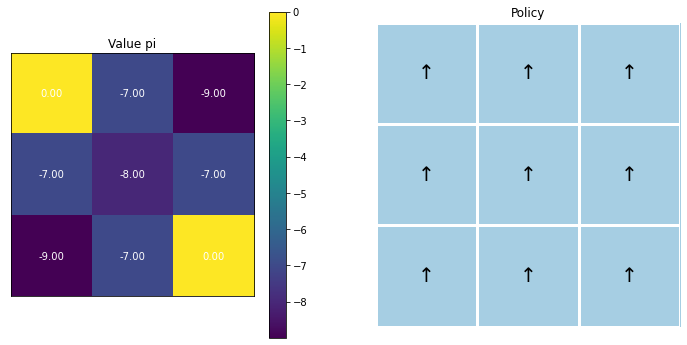

In [68]:
v_pi = dp_agent.policy_evaluation()
fig, ax = plt.subplots(1,2, figsize=(12,6))
visualize_value_function(ax[0], v_pi, nx, ny)
_ = ax[0].set_title("Value pi")
visualize_policy(ax[1], dp_agent.policy, nx, ny)
_ = ax[1].set_title("Policy")
v_old = v_pi # 정책 개선 정리에 대해 설명할때 사용

In [69]:
p_new = dp_agent.policy_improvement()
dp_agent.set_policy(p_new) # DP agent 의 정책을 개선된 정책 `p_new`로 설정

In [80]:
policy_state_dim = dp_agent.policy.shape[0]
policy_action_dim = dp_agent.policy.shape[1]
print("===== 정책함수 스펙 =====")
print("state dimension: {}".format(policy_state_dim))
print("action dimension: {} \n".format(policy_action_dim))

print("===== 정책함수 =====")
print(dp_agent.policy)

===== 정책함수 스펙 =====
state dimension: 9
action dimension: 4 

===== 정책함수 =====
[[0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]]


## "내 정책은 조금 전의 정책보다 개선된다!" 정책 개선

`policy_improvement()` 를 활용해 greedy policy improvement 를 수행합니다.

> Greedy 정책개선
> 1. $V^{\pi}(s)$ 와 $P$, $R$ 를 이용해 $Q^{\pi}(s,a)$ 를 계산한다. <br>
$$Q^\pi(s,a) = R_s^{a} + \gamma \Sigma_{s' \in \cal{S}}P_{ss'}^aV^{\pi}(s')$$

> 2. 개선된 정책 $\pi'(a|s)$ 을 가장 높은 $Q^{\pi}(s,a)$ 값을 주는 $a$ 에 대해서 1로 설정.
나머지는 0.0

파이썬 구현체를 한번 살펴보죠
```python
    def policy_improvement(self, policy=None, v_pi=None):
        if policy is None:
            policy = self.policy

        if v_pi is None:
            v_pi = self.policy_evaluation(policy)

        # (1) Compute Q_pi(s,a) from V_pi(s)
        r_pi = self.get_r_pi(policy)
        q_pi = r_pi + self.P.dot(v_pi)

        # (2) Greedy improvement
        policy_improved = np.zeros_like(policy)
        policy_improved[np.arange(q_pi.shape[1]), q_pi.argmax(axis=0)] = 1
        return policy_improved
```

> `policy_improved = np.zeros_like(policy)`  <br>
개선된 정책 $\pi'$ 는 선택될 action (특정 $s$ 에 대해 가장 큰 $Q(s,a)$를 만족하는 $a$) 이외에는 값이 0 이기 때문에 0으로 초기화 합니다.

> `policy_improved[np.arange(q_pi.shape[1]), q_pi.argmax(axis=0)] = 1` <br>
특정 $s$에 대해 가장 큰 $Q(s,a)$를 만족하는 $a$ 만을 1.0 으로 설정합니다.

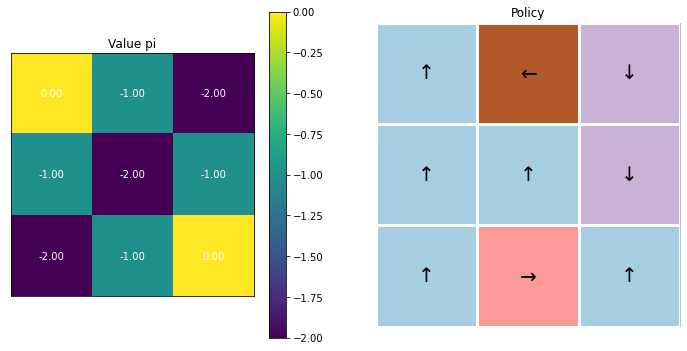

In [71]:
v_pi = dp_agent.policy_evaluation()
fig, ax = plt.subplots(1,2, figsize=(12,6))
visualize_value_function(ax[0], v_pi, nx, ny)
_ = ax[0].set_title("Value pi")
visualize_policy(ax[1], dp_agent.policy, nx, ny)
_ = ax[1].set_title("Policy")

v_new = v_pi # 개선된 정책에 대한 가치함수

## 정책개선 정리 결과 확인해보기

__정책개선 정리__ : 정책 개선 정리를 활용해 구해진 $\pi'$과 개선전 정책 $\pi$는 다음의 관계를 만족한다.
$$\pi' \geq \pi$$

$$\pi' \geq \pi \leftrightarrow V_{\pi'}(s) \geq V_{\pi}(s) \forall s \in S$$

In [83]:
delta_v = v_new - v_old

In [84]:
delta_v

array([0.        , 5.99997909, 6.99997192, 5.99997909, 5.99997603,
       5.99997909, 6.99997192, 5.99997909, 0.        ])